In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
from numba import njit
import pandas as pd

## Summing each cone to make a map, without assuming dipole

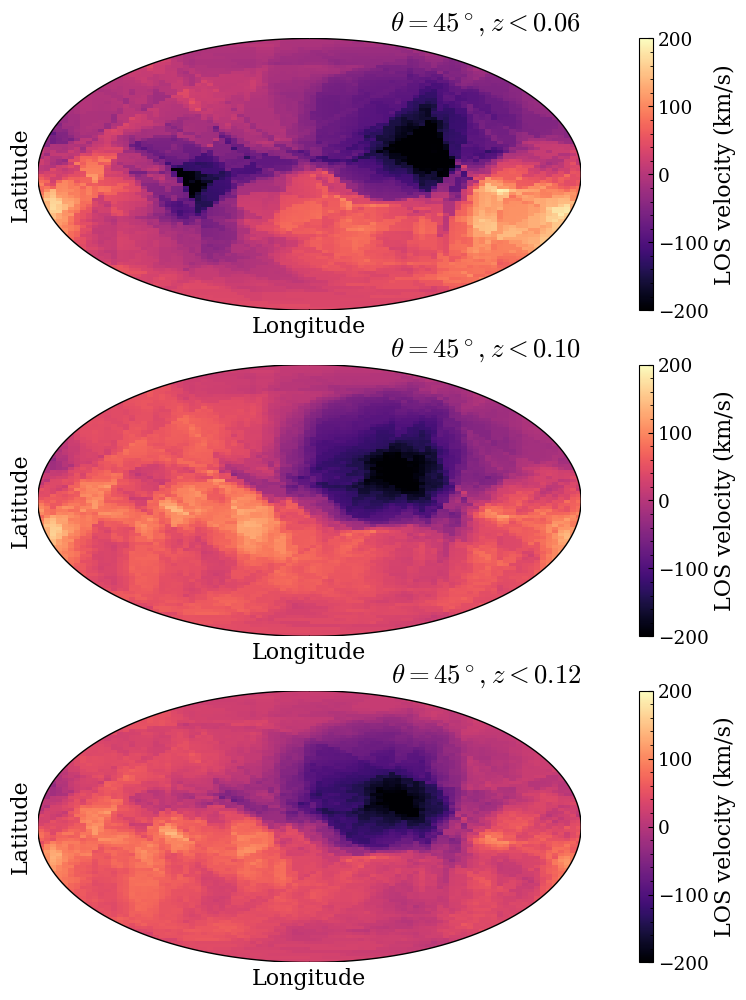

In [12]:
import sys
sys.path.append('../tools/')
import clusterplot as cp
import clusterfit as cf
import matplotlib.pyplot as plt

from mpl_toolkits.basemap import Basemap
# Use hammer projection
m = Basemap(projection='hammer', lon_0=0)

# -------------------------------||Parameters||---------------------------------
cone_size = 45
lon_step = 4
lat_step = 2
n_clusters = 313
data = pd.read_csv('../data/samples_in_lightcone0_with_trees_duplicate_excision_outlier_excision.csv')
#-------------------------------------------------------------------------------


# Only 313 highest Lcore/Ltot clusters
data = data[:n_clusters]

redshift = data['ObservedRedshift']
fig, axes = plt.subplots(3, 1, figsize=(15, 12))
for zmax, ax in zip([0.06, 0.10, 0.12], axes):
    # Select redshift range
    zmask = (redshift < zmax)
    
    # Calculate los velocity map
    _,_,los_v_map,_ = cf.make_los_v_map(data, zmask, cone_size=cone_size, lon_step=lon_step, lat_step=lat_step)
    
    # Plot the map. Negative for that negative los velocity means positive H0 dipole
    cp._sky_map_(-los_v_map, colorbar_label='LOS velocity (km/s)', ax=ax, vmin=-200, vmax=200)

    # Set the title
    ax.set_title(f'$\\theta={cone_size}^\\circ, z<{zmax:.2f}$', loc='right')

    # # Highlight some directions
    # m.scatter(51.49, 13.34, marker='o', ax=ax, latlon=True, edgecolor='r', facecolor='none', s=100)
    # m.scatter(50.17, 19.97, marker='o', ax=ax, latlon=True, edgecolor='r', facecolor='none', s=100)

plt.show()

## True bulk flow, amplitude and direction.
### Method 1: Summing each cluster and average over them.
Without assuming dipole. The bulk flow is the averaged velocity of each cluster.

In [4]:
import astropy.coordinates as coord
data = pd.read_csv('../data/samples_in_lightcone0_with_trees_duplicate_excision.csv')

# Consider only our small samples?
data = data[:n_clusters]

redshift = data['ObservedRedshift']
print(redshift.min(), redshift.max())

# Peculiar los velocity
vx = np.array(data['Vx'])                 # velocities in km/s
vy = np.array(data['Vy'])
vz = np.array(data['Vz'])

x = np.array(data['x_lc'])
y = np.array(data['y_lc'])
z = np.array(data['z_lc'])

los_v = (vx*x + vy*y + vz*z) / (x**2 + y**2 + z**2)**0.5 # in km/s
los_v = np.array(los_v)

v_vecs = los_v[...,None] * np.column_stack([x,y,z]) / (x[...,None]**2 + y[...,None]**2 + z[...,None]**2)**0.5


for zmax in np.arange(0.03, redshift.max()+0.01, 0.02):
    zmask = (redshift < zmax)

    # Mask and sum
    bulk_v = np.sum(v_vecs[zmask,:], axis=0)/np.sum(zmask)
    r, b, l = coord.cartesian_to_spherical(bulk_v[0], bulk_v[1], bulk_v[2]) # r, lat, lon
    print(f"z<{zmax:.2f}, {np.sum(zmask)} haloes {r:.2f} km/s ({l.to('deg').value:.2f}, {b.to('deg').value:.2f})")
    # break

0.0106927399700134 0.1682769161224142
z<0.03, 29 haloes 50.52 km/s (153.31, 11.05)
z<0.05, 88 haloes 23.30 km/s (151.87, 65.88)
z<0.07, 161 haloes 32.19 km/s (52.66, 52.68)
z<0.09, 214 haloes 39.24 km/s (60.89, 43.65)
z<0.11, 248 haloes 38.65 km/s (57.35, 47.49)
z<0.13, 282 haloes 25.49 km/s (46.30, 32.08)
z<0.15, 300 haloes 23.43 km/s (42.82, 23.94)
z<0.17, 313 haloes 20.34 km/s (50.17, 19.97)


### Method 2: Summing all 3-d velocities

In [5]:
import astropy.coordinates as coord
data = pd.read_csv('../data/samples_in_lightcone0_with_trees_duplicate_excision.csv')

# Consider only our small samples?
data = data[:313]

redshift = data['ObservedRedshift']
print(redshift.min(), redshift.max())

# Peculiar los velocity
vx = np.array(data['Vx'])                 # velocities in km/s
vy = np.array(data['Vy'])
vz = np.array(data['Vz'])

v_vecs = np.column_stack([vx, vy, vz])

for zmax in np.arange(0.03, redshift.max()+0.01, 0.02):
    zmask = (redshift < zmax)

    # Mask and sum
    bulk_v = np.sum(v_vecs[zmask,:], axis=0)/np.sum(zmask)
    r, b, l = coord.cartesian_to_spherical(bulk_v[0], bulk_v[1], bulk_v[2]) # r, lat, lon
    print(f"z<{zmax:.2f}, {np.sum(zmask)} haloes {r:.2f} km/s ({l.to('deg').value:.2f}, {b.to('deg').value:.2f})")
    # break

0.0106927399700134 0.1682769161224142
z<0.03, 29 haloes 182.70 km/s (119.77, 37.48)
z<0.05, 88 haloes 100.65 km/s (126.98, 48.82)
z<0.07, 161 haloes 94.94 km/s (84.13, 44.28)
z<0.09, 214 haloes 100.80 km/s (82.78, 44.45)
z<0.11, 248 haloes 98.47 km/s (73.46, 48.18)
z<0.13, 282 haloes 77.84 km/s (65.00, 43.43)
z<0.15, 300 haloes 67.54 km/s (61.46, 41.82)
z<0.17, 313 haloes 55.27 km/s (57.67, 39.38)


### Method 2: Maximum dipole flow of opposing direction

In [6]:
import sys
sys.path.append('/data1/yujiehe/anisotropy-flamingo')
import tools.clusterfit as cf

@njit(fastmath=True)
def find_max_dipole_flow(Glon, Glat, los_v_map, count_map):
    # Find the maximum dipole flow
    max_ubf_dp = 0
    for lon, lat in zip(Glon, Glat):
        if lon < 0: # only do half of the sky
            continue

        # current direction
        los_v = los_v_map[(Glon == lon) & (Glat == lat)]
        count = count_map[(Glon == lon) & (Glat == lat)]

        # get the dipole direction
        dp_lon, dp_lat = cf.opposite_direction(lon, lat)
        dp_mask = (Glon == dp_lon) & (Glat == dp_lat)
        dp_los_v = los_v_map[dp_mask]
        dp_count = count_map[dp_mask]

        # calculate the dipole flow, weighted using number of clusters
        if np.sum(count + dp_count) > 5:
            ubf_dp = (los_v*count - dp_los_v*dp_count)/(count + dp_count)
            ubf_dp = ubf_dp[0]
            if np.abs(ubf_dp) > np.abs(max_ubf_dp): # Find the maximum
                if ubf_dp > 0:
                    max_ubf_dp = ubf_dp
                    max_bf_lon = lon
                    max_bf_lat = lat
                else:
                    max_ubf_dp = -ubf_dp
                    max_bf_lon = dp_lon
                    max_bf_lat = dp_lat

    return max_ubf_dp, max_bf_lon, max_bf_lat

### The "true" bulk flow only

In [7]:

# import matplotlib.pyplot as plt
# import numpy as np
# from astropy.cosmology import FlatLambdaCDM
# cosmo = FlatLambdaCDM(H0=68.1, Om0=0.306)
# fig, ax = plt.subplots(figsize=(10, 6))



# # Calculate and plot the bulk flow for the first lightcone
# for i, marker in enumerate(['o', 's']):
#     for cone_size in [30, 45, 60]:
#         data = pd.read_csv(f'../data/samples_in_lightcone{i}_with_trees_duplicate_excision.csv')
#         zmaxs, ubfs, vlons, vlats = cf.true_bulk_flow_z(data, cone_size=cone_size,
#                                                      n_clusters=313) # ubf_z returns a list
#         zmaxs = np.array(zmaxs)

#         ax.plot(zmaxs, ubfs, marker=marker, label=f'$\\theta={cone_size}^\\circ$, Lightcone{i}')



# # Set up the plot
# ax.set_xlabel('Redshift')
# ax.set_ylabel('Bulk flow amplitude (km/s)')
# ax.set_xticks(np.linspace(0, 0.2, 11))

# # set a double x label for redshift
# ax2 = ax.twiny()
# ax2.set_xlim(0, 0.2)
# ax2.set_xticks(np.linspace(0, 0.2, 11))                    # this line maps the x values to the new x axis
# Dco = cosmo.comoving_distance(np.linspace(0,0.2,11)).value # this line sets the tick labels for the new x axis
# xtickslabels = np.round(Dco, -1)
# xtickslabels = np.array(xtickslabels, dtype=int) 
# ax2.set_xticklabels(xtickslabels) # this line sets the tick labels for the new x axis
# ax2.set_xlabel('Distance (Mpc)')

# ax.grid(True)
# ax.set_xlim(0, 0.2)
# ax.set_ylim(0, 750)

# # legend on the bottom ouside of the plot
# ax.legend(loc='upper center', shadow=True, ncol=2)
# plt.show()

## Compare with the modeled bulk flow

z<0.03, 29 haloes 182.70 km/s (119.77, 37.48)
z<0.04, 61 haloes 169.70 km/s (117.12, 54.32)
z<0.05, 88 haloes 100.65 km/s (126.98, 48.82)
z<0.06, 138 haloes 98.35 km/s (89.29, 48.44)
z<0.07, 161 haloes 94.94 km/s (84.13, 44.28)
z<0.08, 184 haloes 96.62 km/s (90.86, 50.10)
z<0.09, 214 haloes 100.80 km/s (82.78, 44.45)
z<0.10, 227 haloes 96.98 km/s (83.33, 44.97)
z<0.11, 248 haloes 98.47 km/s (73.46, 48.18)
z<0.12, 267 haloes 87.73 km/s (69.85, 42.42)
z<0.13, 282 haloes 77.84 km/s (65.00, 43.43)
z<0.14, 294 haloes 72.61 km/s (60.40, 41.67)
z<0.15, 300 haloes 67.54 km/s (61.46, 41.82)


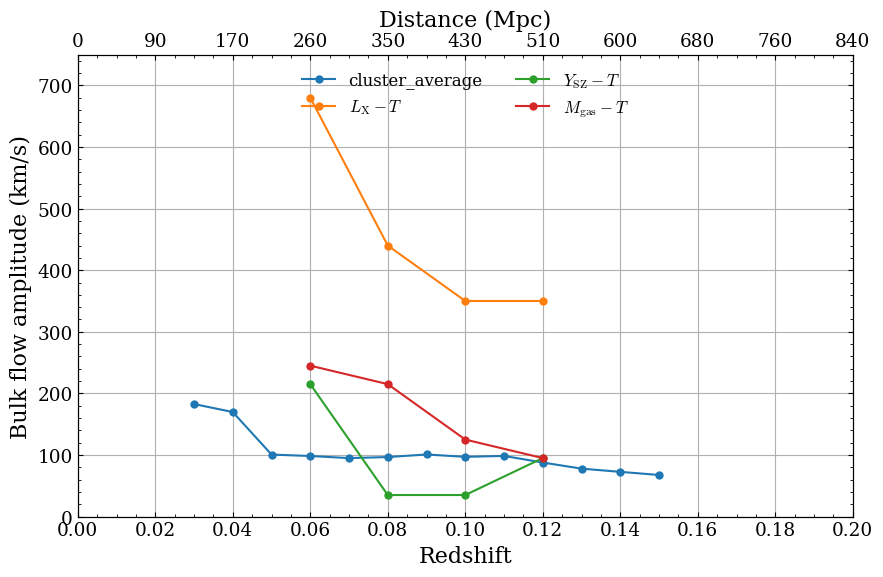

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=68.1, Om0=0.306)
fig, ax = plt.subplots(figsize=(10, 6))

# Lightcone number
i = 0

# Calculate and plot the bulk flow for the first lightcone
data = pd.read_csv(f'../data/samples_in_lightcone{i}_with_trees_duplicate_excision.csv')
for method in ['cluster_average']:
    zmaxs, ubfs, vlons, vlats = cf.true_bulk_flow_z(data, method) # ubf_z returns a list
    zmaxs = np.array(zmaxs)

    ax.plot(zmaxs, ubfs, marker='o', label=f'{method}')



# Plot the modeled bulk flow
df = pd.read_csv(f'../data/fits/bulk_flow_lightcone{i}.csv')
for relation, label in zip(['LX-T', 'YSZ-T', 'M-T'], ['$L_\\mathrm{{X}}-T$', '$Y_\\mathrm{{SZ}}-T$', '$M_\\mathrm{{gas}}-T$']):
    zmax = df['zmax'].loc[df['scaling_relation']==relation] # Do LX-T for now
    ubfs = df['ubf'].loc[df['scaling_relation']==relation]
    zmaxs = np.array(zmax)
    ax.plot(zmaxs, ubfs, marker='o', label=f'{label}')



# Set up the plot
ax.set_xlabel('Redshift')
ax.set_ylabel('Bulk flow amplitude (km/s)')
ax.set_xticks(np.linspace(0, 0.2, 11))

# set a double x label for redshift
ax2 = ax.twiny()
ax2.set_xlim(0, 0.2)
ax2.set_xticks(np.linspace(0, 0.2, 11))                    # this line maps the x values to the new x axis
Dco = cosmo.comoving_distance(np.linspace(0,0.2,11)).value # this line sets the tick labels for the new x axis
xtickslabels = np.round(Dco, -1)
xtickslabels = np.array(xtickslabels, dtype=int) 
ax2.set_xticklabels(xtickslabels) # this line sets the tick labels for the new x axis
ax2.set_xlabel('Distance (Mpc)')

ax.grid(True)
ax.set_xlim(0, 0.2)
ax.set_ylim(0, 750)

# legend on the bottom ouside of the plot
ax.legend(loc='upper center', shadow=True, ncol=2)
plt.show()

z<0.03, 37 haloes 244.55 km/s (198.25, 19.06)
z<0.04, 53 haloes 197.68 km/s (203.90, 32.23)
z<0.05, 87 haloes 204.47 km/s (210.50, 12.95)
z<0.06, 114 haloes 184.63 km/s (210.24, 6.93)
z<0.07, 151 haloes 173.48 km/s (204.13, 1.84)
z<0.08, 183 haloes 149.16 km/s (201.26, -5.66)
z<0.09, 212 haloes 145.37 km/s (205.11, -8.60)
z<0.10, 237 haloes 133.43 km/s (208.23, -9.32)
z<0.11, 263 haloes 123.39 km/s (209.77, -10.94)
z<0.12, 277 haloes 117.37 km/s (210.22, -6.92)
z<0.13, 291 haloes 116.57 km/s (208.67, -5.27)
z<0.14, 298 haloes 114.53 km/s (211.09, -4.00)
z<0.15, 303 haloes 113.03 km/s (211.89, -1.99)


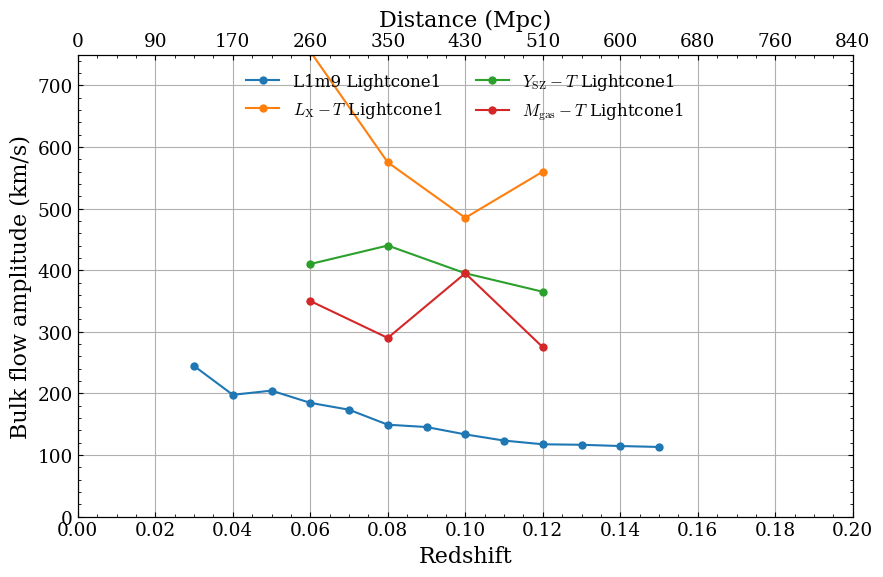

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=68.1, Om0=0.306)
fig, ax = plt.subplots(figsize=(10, 6))

# Lightcone number
i = 1

# Calculate and plot the bulk flow for the first lightcone
data = pd.read_csv(f'../data/samples_in_lightcone{i}_with_trees_duplicate_excision.csv')
zmaxs, ubfs, vlons, vlats = cf.true_bulk_flow_z(data) # ubf_z returns a list
zmaxs = np.array(zmaxs)

ax.plot(zmaxs, ubfs, marker='o', label=f'L1m9 Lightcone{i}')



# Plot the modeled bulk flow
df = pd.read_csv(f'../data/fits/bulk_flow_lightcone{i}.csv')
for relation, label in zip(['LX-T', 'YSZ-T', 'M-T'], ['$L_\\mathrm{{X}}-T$', '$Y_\\mathrm{{SZ}}-T$', '$M_\\mathrm{{gas}}-T$']):
    zmax = df['zmax'].loc[df['scaling_relation']==relation] # Do LX-T for now
    ubfs = df['ubf'].loc[df['scaling_relation']==relation]
    zmaxs = np.array(zmax)
    ax.plot(zmaxs, ubfs, marker='o', label=f'{label} Lightcone{i}')



# Set up the plot
ax.set_xlabel('Redshift')
ax.set_ylabel('Bulk flow amplitude (km/s)')
ax.set_xticks(np.linspace(0, 0.2, 11))

# set a double x label for redshift
ax2 = ax.twiny()
ax2.set_xlim(0, 0.2)
ax2.set_xticks(np.linspace(0, 0.2, 11))                    # this line maps the x values to the new x axis
Dco = cosmo.comoving_distance(np.linspace(0,0.2,11)).value # this line sets the tick labels for the new x axis
xtickslabels = np.round(Dco, -1)
xtickslabels = np.array(xtickslabels, dtype=int) 
ax2.set_xticklabels(xtickslabels) # this line sets the tick labels for the new x axis
ax2.set_xlabel('Distance (Mpc)')

ax.grid(True)
ax.set_xlim(0, 0.2)
ax.set_ylim(0, 750)

# legend on the bottom ouside of the plot
ax.legend(loc='upper center', shadow=True, ncol=2)
plt.show()

## The direction

In [7]:
#independent
# Calculate true bulk flow as a function of z
import pandas as pd
import sys
sys.path.append('../tools/')
import clusterplot as cp

# Lightcone number
i = 0

data = pd.read_csv(f'../data/samples_in_lightcone{i}_with_trees_duplicate_excision.csv')
zmaxs, ubfs, vlons, vlats = cf.true_bulk_flow_z(data) # ubf_z returns a list

z<0.03, 29 haloes 182.70 km/s (119.77, 37.48)
z<0.04, 61 haloes 169.70 km/s (117.12, 54.32)
z<0.05, 88 haloes 100.65 km/s (126.98, 48.82)
z<0.06, 138 haloes 98.35 km/s (89.29, 48.44)
z<0.07, 161 haloes 94.94 km/s (84.13, 44.28)
z<0.08, 184 haloes 96.62 km/s (90.86, 50.10)


z<0.09, 214 haloes 100.80 km/s (82.78, 44.45)
z<0.10, 227 haloes 96.98 km/s (83.33, 44.97)
z<0.11, 248 haloes 98.47 km/s (73.46, 48.18)
z<0.12, 267 haloes 87.73 km/s (69.85, 42.42)
z<0.13, 282 haloes 77.84 km/s (65.00, 43.43)
z<0.14, 294 haloes 72.61 km/s (60.40, 41.67)
z<0.15, 300 haloes 67.54 km/s (61.46, 41.82)


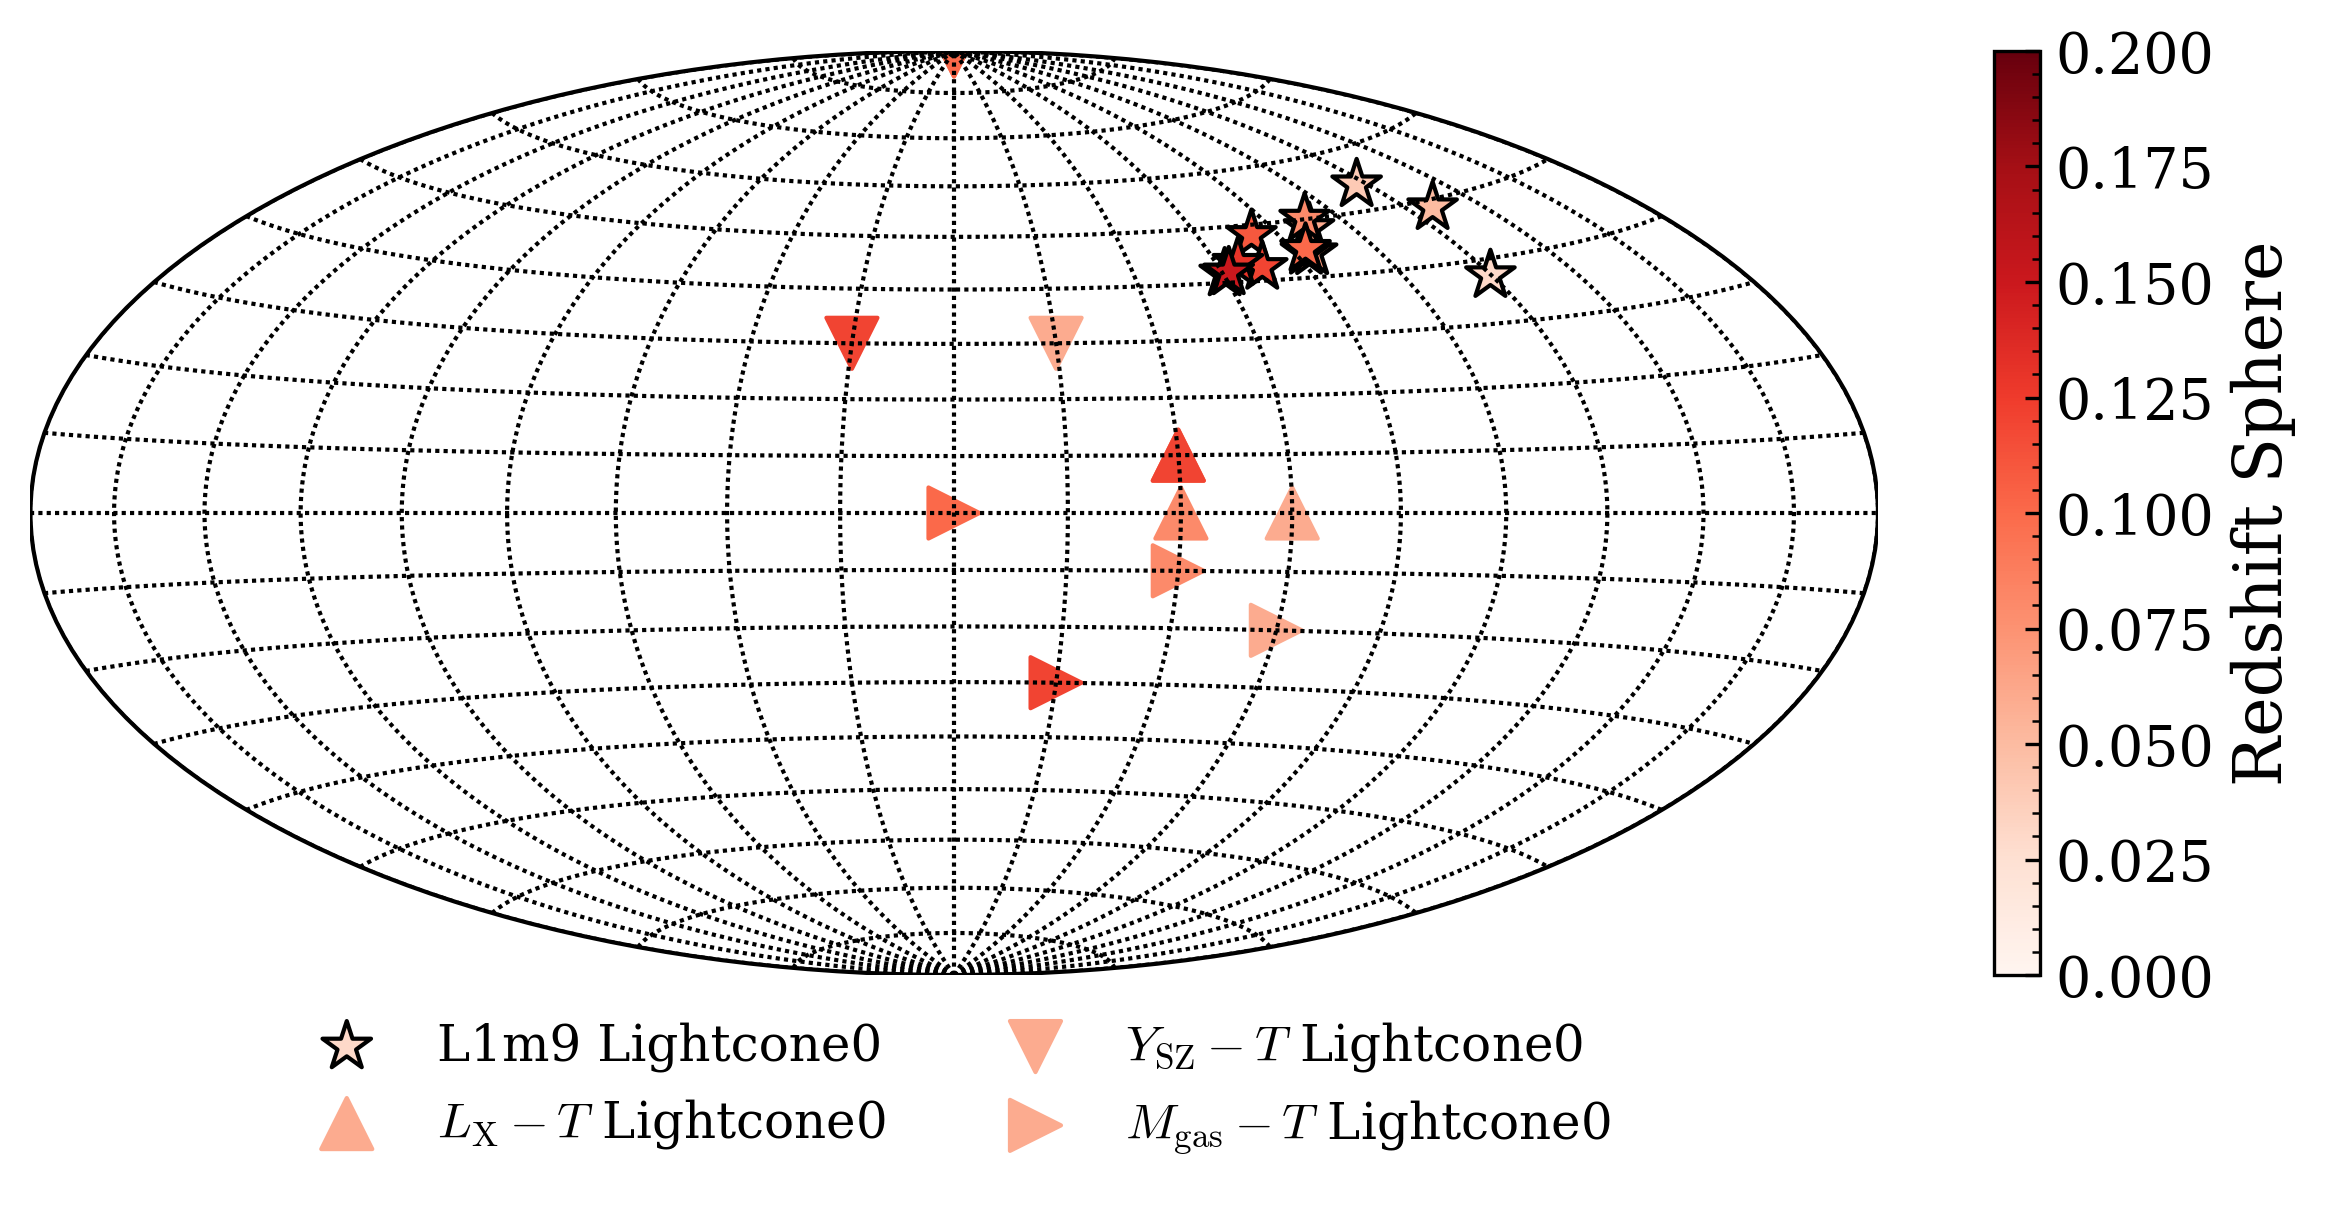

In [8]:
# Use hammer projection
fig, ax = plt.subplots(figsize=(10, 4), dpi=300)
m = Basemap(projection='hammer', lon_0=0)


# Calculate and plot the bulk flow for the first lightcone
m.scatter(vlons, vlats, marker='*', c=zmaxs, label=f'L1m9 Lightcone{i}', 
            latlon=True, cmap='Reds', vmin=0, vmax=0.2, 
            edgecolors='black', s=150)
# m.plot(vlons, vlats, latlon=True, zorder=-1, alpha=0.5)

# Plot the modeled bulk flow
markers = ['^','v','>']
j = 0 # marker index
df = pd.read_csv(f'../data/fits/bulk_flow_lightcone{i}.csv')
for relation, label in zip(['LX-T', 'YSZ-T', 'M-T'], ['$L_\\mathrm{{X}}-T$', '$Y_\\mathrm{{SZ}}-T$', '$M_\\mathrm{{gas}}-T$']):
    zmaxs = df['zmax'].loc[df['scaling_relation']==relation]
    vlons = df['lon'].loc[df['scaling_relation']==relation]
    vlats = df['lat'].loc[df['scaling_relation']==relation]
    vlons = np.array(vlons)
    vlats = np.array(vlats)
    vlons, vlats = cf.opposite_direction_arr(vlons, vlats)
    m.scatter(vlons, vlats, marker=markers[j], c=zmaxs, 
                label=f'{label} Lightcone{i}', latlon=True, cmap='Reds', 
                vmin=0, vmax=0.2, s=150)
    # m.plot(vlons, vlats, latlon=True, zorder=-1, alpha=0.5)

    # Add a marker index
    j += 1

    
m.drawparallels(np.arange(-90,90,10.))
m.drawmeridians(np.arange(-180,180,20.))

# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
ax.legend(loc='lower center', shadow=True, ncol=2, bbox_to_anchor=(0.5, -0.25))
plt.colorbar(label='Redshift Sphere')
plt.show()

z<0.03, 37 haloes 244.55 km/s (198.25, 19.06)
z<0.04, 53 haloes 197.68 km/s (203.90, 32.23)
z<0.05, 87 haloes 204.47 km/s (210.50, 12.95)
z<0.06, 114 haloes 184.63 km/s (210.24, 6.93)
z<0.07, 151 haloes 173.48 km/s (204.13, 1.84)
z<0.08, 183 haloes 149.16 km/s (201.26, -5.66)
z<0.09, 212 haloes 145.37 km/s (205.11, -8.60)
z<0.10, 237 haloes 133.43 km/s (208.23, -9.32)
z<0.11, 263 haloes 123.39 km/s (209.77, -10.94)
z<0.12, 277 haloes 117.37 km/s (210.22, -6.92)
z<0.13, 291 haloes 116.57 km/s (208.67, -5.27)
z<0.14, 298 haloes 114.53 km/s (211.09, -4.00)
z<0.15, 303 haloes 113.03 km/s (211.89, -1.99)


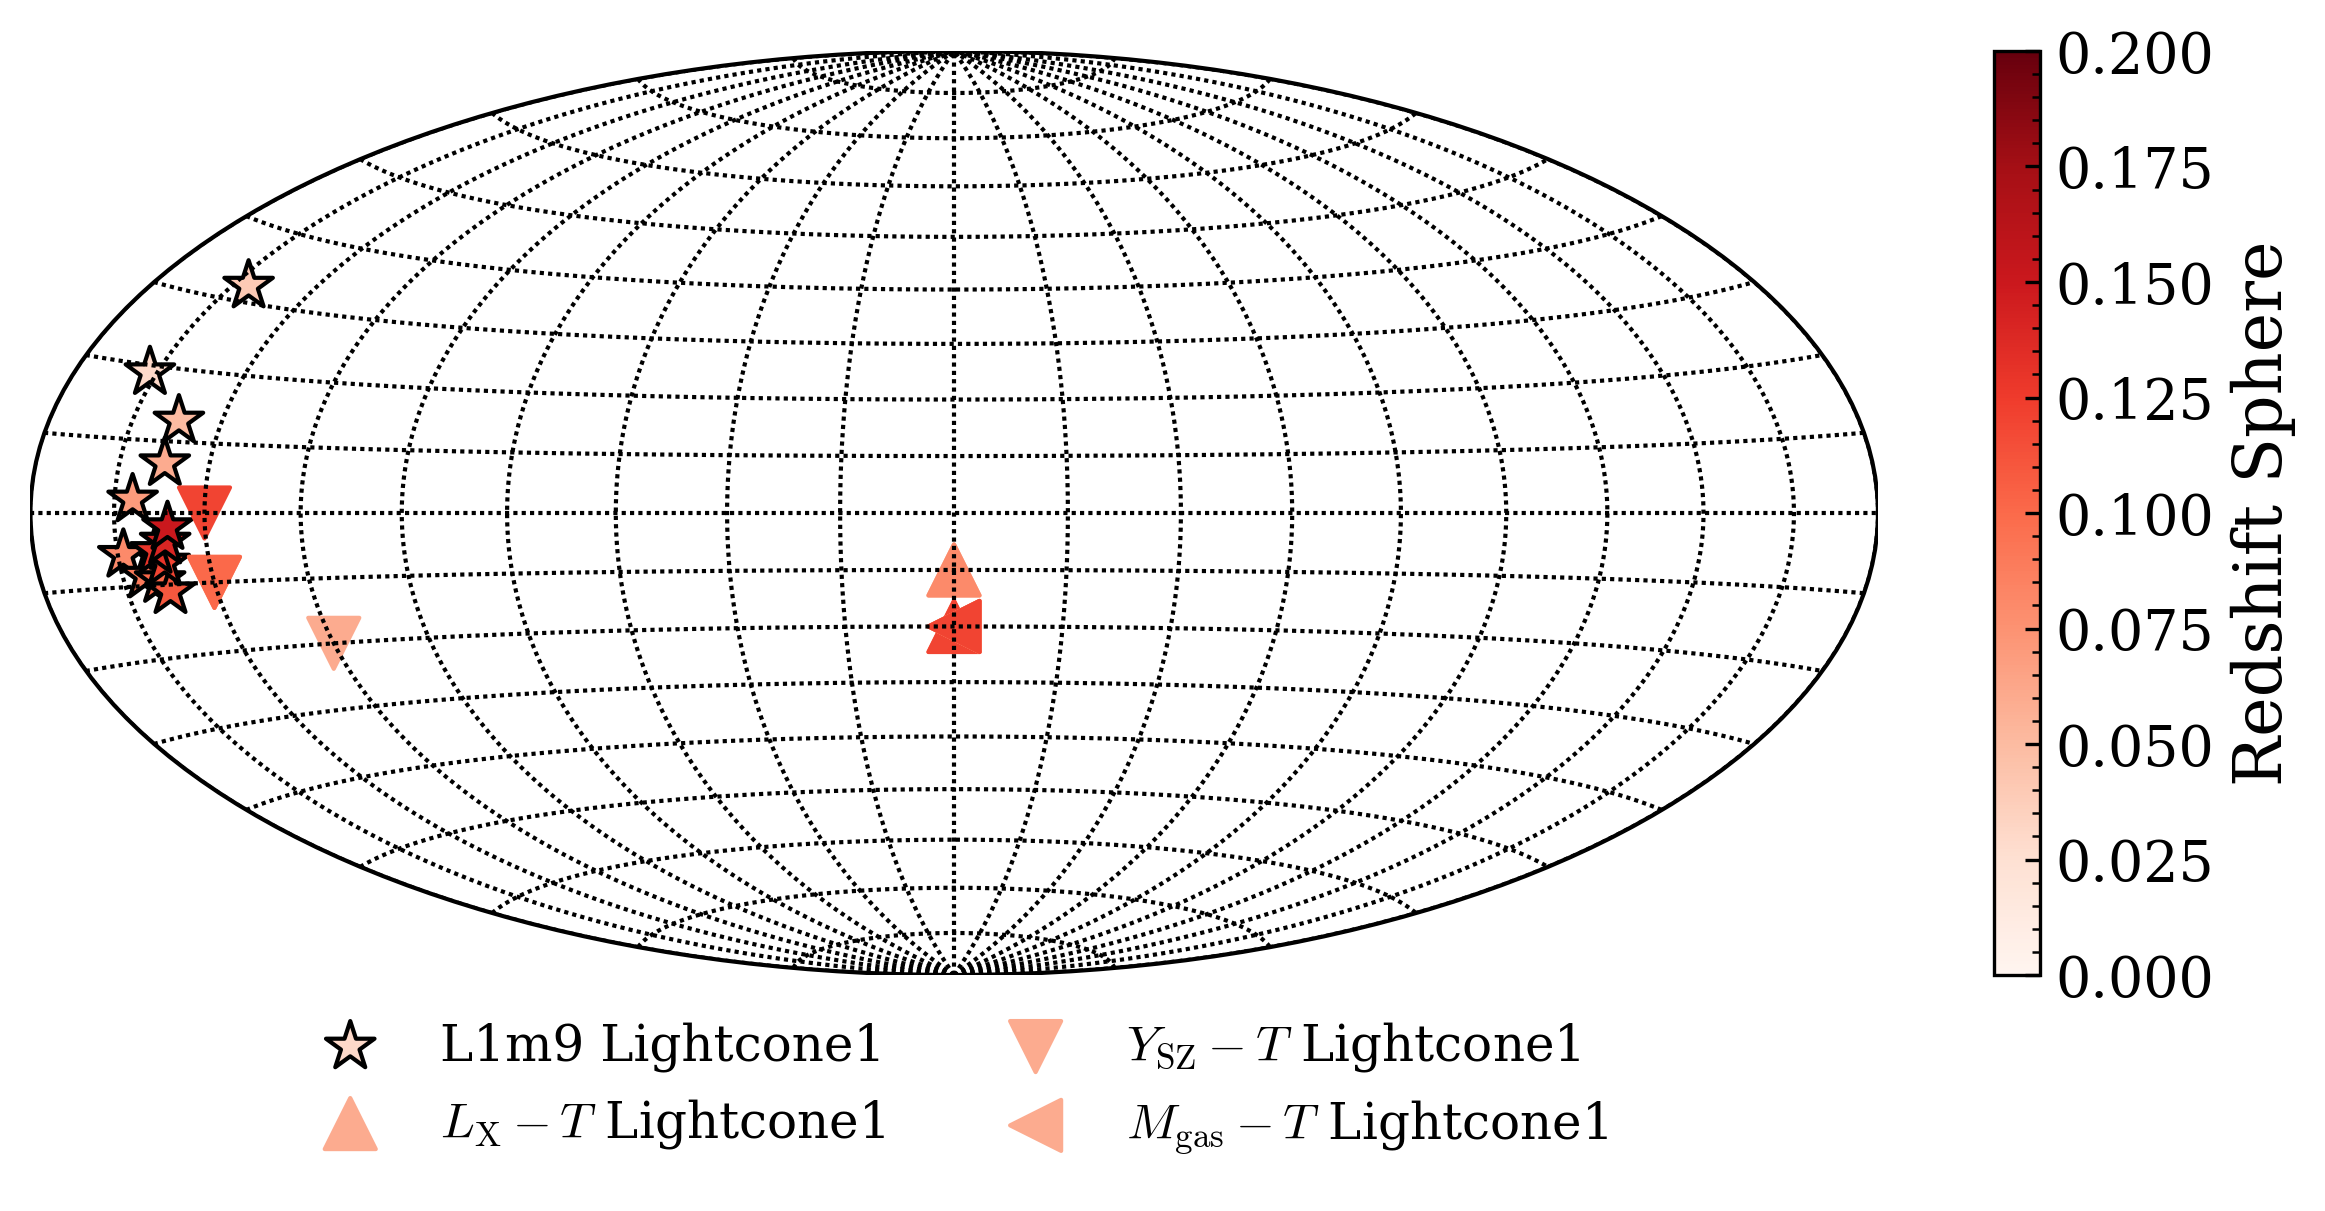

In [11]:
import sys
sys.path.append('../tools/')
import clusterplot as cp
from adjustText import adjust_text

# Lightcone number
i = 1

# Use hammer projection
fig, ax = plt.subplots(figsize=(10, 4), dpi=300)
m = Basemap(projection='hammer', lon_0=0)

# texts = [] # for adjusting texts

# Calculate and plot the bulk flow for the first lightcone
data = pd.read_csv(f'../data/samples_in_lightcone{i}_with_trees_duplicate_excision.csv')
zmaxs, ubfs, vlons, vlats = cf.true_bulk_flow_z(data) # ubf_z returns a list
m.scatter(vlons, vlats, marker='*', c=zmaxs, label=f'L1m9 Lightcone{i}', 
            latlon=True, cmap='Reds', vmin=0, vmax=0.2, 
            edgecolors='black', s=150)
# m.plot(vlons, vlats, latlon=True, zorder=-1, alpha=0.5)



# Plot the modeled bulk flow
markers = ['^','v','<']
j = 0 # marker index
df = pd.read_csv(f'../data/fits/bulk_flow_lightcone{i}.csv')
for relation, label in zip(['LX-T', 'YSZ-T', 'M-T'], ['$L_\\mathrm{{X}}-T$', '$Y_\\mathrm{{SZ}}-T$', '$M_\\mathrm{{gas}}-T$']):
    zmaxs = df['zmax'].loc[df['scaling_relation']==relation]
    vlons = df['lon'].loc[df['scaling_relation']==relation]
    vlats = df['lat'].loc[df['scaling_relation']==relation]
    zmaxs = np.array(zmaxs)
    vlons = np.array(vlons)
    vlats = np.array(vlats)
    vlons, vlats = cf.opposite_direction_arr(vlons, vlats)
    m.scatter(vlons, vlats, marker=markers[j], c=zmaxs, 
                label=f'{label} Lightcone{i}', latlon=True, cmap='Reds', 
                vmin=0, vmax=0.2, s=150)
    
    # for k, zmax in enumerate(zmaxs):
    #     x, y = m(vlons[k], vlats[k])
    #     # ax.annotate(f'z<{zmax}', (x, y), fontsize=8, color='black')
    #     texts.append(ax.annotate(f'z<{zmax}', (x, y-zmax-1), fontsize=8, color='black'))
    # m.plot(vlons, vlats, latlon=True, zorder=-1, alpha=0.5)

    # Add a marker index
    j += 1

# Adjust the texts
# adjust_text(texts, only_move='y-', ax=ax)

m.drawparallels(np.arange(-90,90,10.))
m.drawmeridians(np.arange(-180,180,20.))

# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
ax.legend(loc='lower center', shadow=True, ncol=2, bbox_to_anchor=(0.5, -0.25))
plt.colorbar(label='Redshift Sphere')
plt.show()

## MCMC results 

z<0.03, 29 haloes 182.70 km/s (119.77, 37.48)
z<0.04, 61 haloes 169.70 km/s (117.12, 54.32)
z<0.05, 88 haloes 100.65 km/s (126.98, 48.82)
z<0.06, 138 haloes 98.35 km/s (89.29, 48.44)
z<0.07, 161 haloes 94.94 km/s (84.13, 44.28)
z<0.08, 184 haloes 96.62 km/s (90.86, 50.10)
z<0.09, 214 haloes 100.80 km/s (82.78, 44.45)
z<0.10, 227 haloes 96.98 km/s (83.33, 44.97)
z<0.11, 248 haloes 98.47 km/s (73.46, 48.18)
z<0.12, 267 haloes 87.73 km/s (69.85, 42.42)
z<0.13, 282 haloes 77.84 km/s (65.00, 43.43)
z<0.14, 294 haloes 72.61 km/s (60.40, 41.67)
z<0.15, 300 haloes 67.54 km/s (61.46, 41.82)


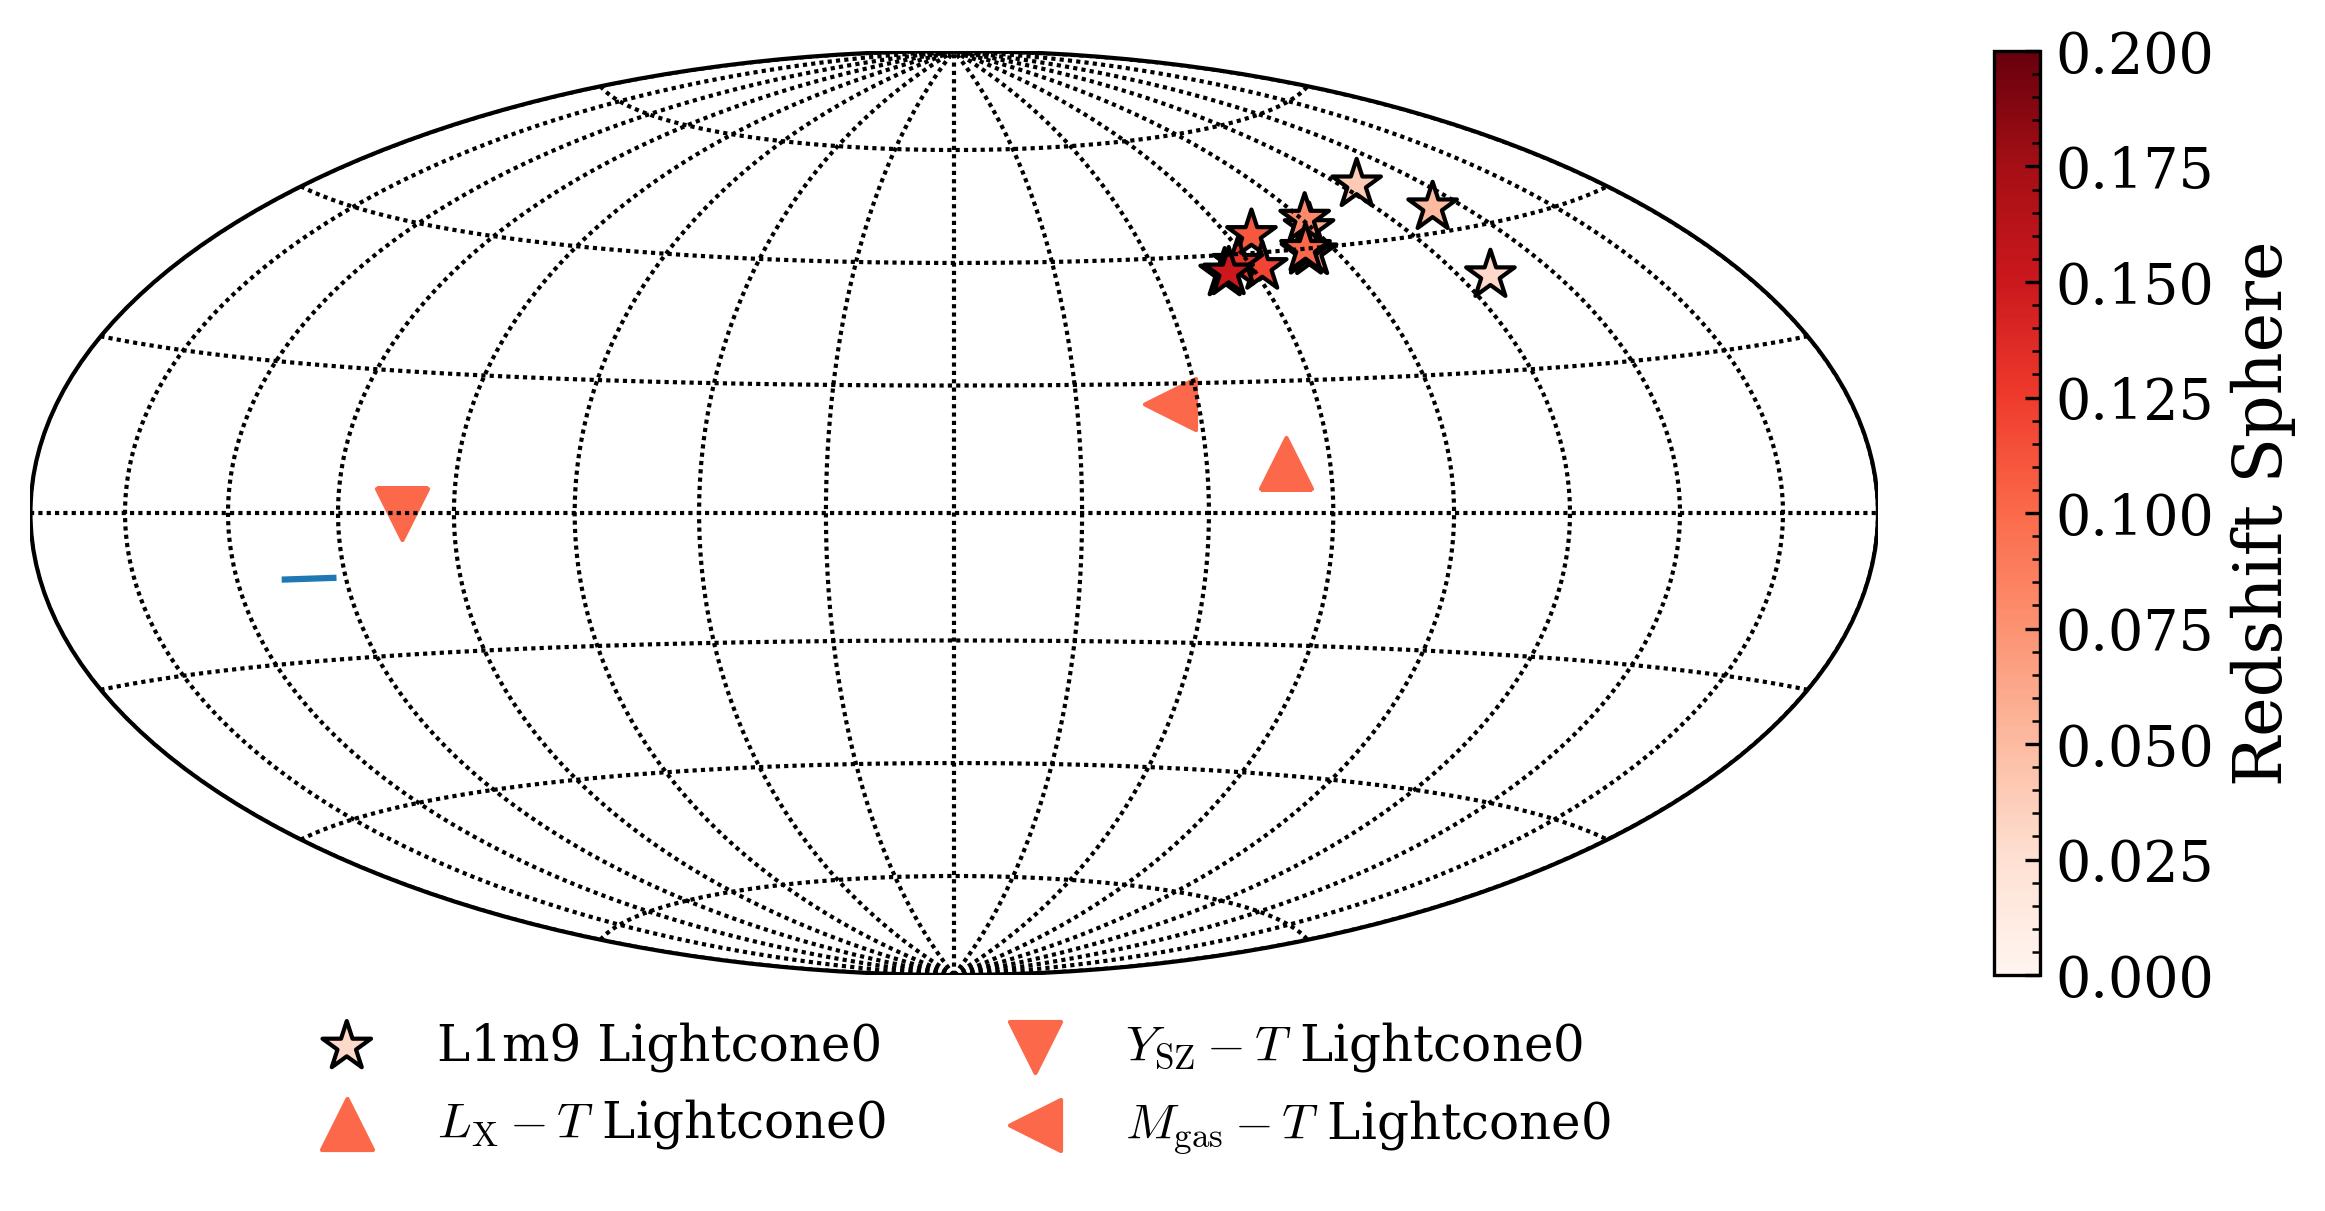

In [39]:
import sys
sys.path.append('../tools/')
import clusterplot as cp

# Lightcone number
i = 0

# Use hammer projection
fig, ax = plt.subplots(figsize=(10, 4), dpi=300)
m = Basemap(projection='hammer', lon_0=0)


# Calculate and plot the bulk flow for the first lightcone
data = pd.read_csv(f'../data/samples_in_lightcone{i}_with_trees_duplicate_excision.csv')
zmaxs, ubfs, vlons, vlats = cf.true_bulk_flow_z(data) # ubf_z returns a list
m.scatter(vlons, vlats, marker='*', c=zmaxs, label=f'L1m9 Lightcone{i}', 
            latlon=True, cmap='Reds', vmin=0, vmax=0.2, 
            edgecolors='black', s=150)


# Plot the modeled bulk flow
markers = ['^','v','<']

# LX-T
label = '$L_\\mathrm{{X}}-T$'
zmaxs = [0.1]
vlons = [-120.594]
vlats = [-8.434]
vlons, vlats = cf.opposite_direction_arr(vlons, vlats)
m.scatter(vlons, vlats, marker=markers[0], c=zmaxs, 
            label=f'{label} Lightcone{i}', latlon=True, cmap='Reds', 
            vmin=0, vmax=0.2, s=150)


# YSZ-T
label = '$Y_\\mathrm{{SZ}}-T$'
zmaxs = [0.1]
vlons = [80]
vlats = [0.2]
vlons, vlats = cf.opposite_direction_arr(vlons, vlats)
m.scatter(vlons, vlats, marker=markers[1], c=zmaxs, 
            label=f'{label} Lightcone{i}', latlon=True, cmap='Reds', 
            vmin=0, vmax=0.2, s=150)

# Mgas-T
label = '$M_\\mathrm{{gas}}-T$'
zmaxs = [0.1]
vlons = [-140.3]
vlats = [-18.9]
vlons, vlats = cf.opposite_direction_arr(vlons, vlats)
m.scatter(vlons, vlats, marker=markers[2], c=zmaxs, 
            label=f'{label} Lightcone{i}', latlon=True, cmap='Reds', 
            vmin=0, vmax=0.2, s=150)
    
m.drawparallels(np.arange(-90,90,22.5))
m.drawmeridians(np.arange(-180,180,22.5))

# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
ax.legend(loc='lower center', shadow=True, ncol=2, bbox_to_anchor=(0.5, -0.25))
plt.colorbar(label='Redshift Sphere')
plt.show()

z<0.03, 97 haloes 169.15 km/s (93.34, 50.29)
z<0.04, 172 haloes 157.24 km/s (100.59, 53.93)
z<0.05, 244 haloes 123.68 km/s (99.58, 50.24)
z<0.06, 344 haloes 107.90 km/s (87.62, 44.05)
z<0.07, 391 haloes 100.29 km/s (81.94, 39.14)
z<0.08, 447 haloes 98.06 km/s (85.39, 40.57)
z<0.09, 507 haloes 93.12 km/s (81.62, 37.39)
z<0.10, 544 haloes 90.11 km/s (82.15, 36.71)
z<0.11, 595 haloes 84.77 km/s (76.54, 37.76)
z<0.12, 626 haloes 80.44 km/s (73.60, 34.55)
z<0.13, 653 haloes 75.23 km/s (74.25, 34.01)
z<0.14, 673 haloes 70.64 km/s (70.98, 31.65)
z<0.15, 690 haloes 69.27 km/s (69.27, 31.98)


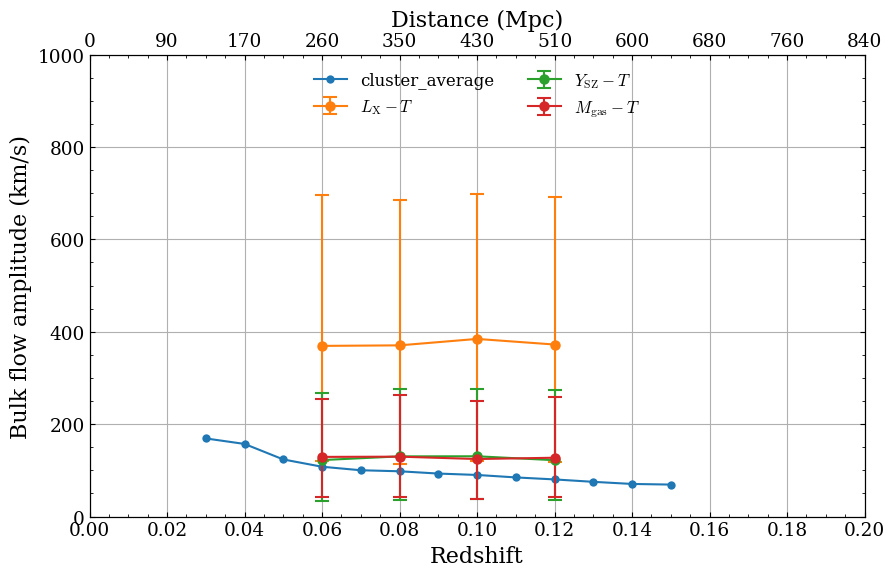

In [6]:
import matplotlib.pyplot as plt
plt.style.use('nice.mplstyle')
import numpy as np
import pandas as pd
import sys
sys.path.append('../')
import tools.clusterfit as cf
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=68.1, Om0=0.306)
fig, ax = plt.subplots(figsize=(10, 6))

# Lightcone number
i = 0

# Calculate and plot the bulk flow for the first lightcone
data = pd.read_csv(f'../data/samples_in_lightcone{i}_with_trees_duplicate_excision.csv')
for method in ['cluster_average']:
    zmaxs, ubfs, vlons, vlats = cf.true_bulk_flow_z(data, method, n_clusters=len(data)) # ubf_z returns a list
    zmaxs = np.array(zmaxs)

    ax.plot(zmaxs, ubfs, marker='o', label=f'{method}')

# 
df = pd.read_csv(f'../data/fits/bulk_flow_mcmc_lightcone0.csv')
for relation, label in zip(['LX-T', 'YSZ-T', 'M-T'], ['$L_\\mathrm{{X}}-T$', '$Y_\\mathrm{{SZ}}-T$', '$M_\\mathrm{{gas}}-T$']):
    # Select the relation 
    mask = df['scaling_relation']==relation

    # Get the data
    zmaxs = df['zmax'].loc[mask] # Do LX-T for now
    ubfs  = df['ubf'].loc[mask]
    yerr1 = df['ubf_err_lower'].loc[mask]
    yerr2 = df['ubf_err_upper'].loc[mask]
    
    # Type change
    zmaxs = np.array(zmaxs)
    ubfs = np.array(ubfs)
    yerr1 = np.array(yerr1)
    yerr2 = np.array(yerr2)

    # Plot the data
    ax.errorbar(zmaxs, ubfs, yerr=[yerr1, yerr2], marker='o', label=f'{label}', capsize=5, elinewidth=1.5, markeredgewidth=1.5)

# Set up the plot
ax.set_xlabel('Redshift')
ax.set_ylabel('Bulk flow amplitude (km/s)')
ax.set_xticks(np.linspace(0, 0.2, 11))

# set a double x label for redshift
ax2 = ax.twiny()
ax2.set_xlim(0, 0.2)
ax2.set_xticks(np.linspace(0, 0.2, 11))                    # this line maps the x values to the new x axis

# Calculate comoving distance
Dco = cosmo.comoving_distance(np.linspace(0,0.2,11)).value # this line sets the tick labels for the new x axis
xtickslabels = np.round(Dco, -1)
xtickslabels = np.array(xtickslabels, dtype=int) 
ax2.set_xticklabels(xtickslabels) # this line sets the tick labels for the new x axis
ax2.set_xlabel('Distance (Mpc)')

ax.grid(True)
ax.set_xlim(0, 0.2)
ax.set_ylim(0, 1000)

# legend on the bottom ouside of the plot
ax.legend(loc='upper center', shadow=True, ncol=2)
plt.show()